## This notebook is used to preprocess data and transform into an appropriate format for an LSTM

In [1]:
from pandas import read_csv
from datetime import datetime
from matplotlib import pyplot
from pandas import DataFrame
from pandas import concat
import pandas
from sklearn import datasets
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
import numpy as np

Create a mapping to transform the dataset into columns per sensor

Load the dataset.

In [2]:
dataset = read_csv('datasets/hh101/hh101.csv', names=["Sensor",1,2,"Value","Type"])
dataset.drop(columns={1,2,"Type"}, inplace=True)
dataset["Value"] = dataset["Value"].replace({"ON" : 1.0, "OFF" : 0.0})
dataset["Value"] = dataset["Value"].replace({"ABSENT" : 1.0, "PRESENT" : 0.0})
dataset["Value"] = dataset["Value"].replace({"OPEN" : 1.0, "CLOSE" : 0.0})
print(dataset)

count = 0
sensor_id_mapping = {}
for sensor in dataset["Sensor"].values:
    if sensor not in sensor_id_mapping:
        sensor_id_mapping[sensor] = count
        count+=1
# # transform sensorids from text into numbers to make life easier
# dataset["SensorId"].replace(replacement_mapping_dict, inplace=True)
# # drop the event labelling as we aren't predicting activities
# dataset.drop('Event', axis=1, inplace=True)

                             Sensor Value
2012-07-18 12:54:45.126257     D001   0.0
2012-07-18 12:54:45.196564     D002   1.0
2012-07-18 12:54:45.247825     T102    78
2012-07-18 12:54:45.302398  BATP102    85
2012-07-18 12:54:45.399416     T103    25
...                             ...   ...
2013-01-27 06:45:57.801259    MA016   1.0
2013-01-27 06:45:58.558745     M002   1.0
2013-01-27 06:46:01.539419     M002   0.0
2013-01-27 06:46:02.411169    LS004     3
2013-01-27 06:46:02.441764     M004   1.0

[1000000 rows x 2 columns]


Now, create a transformed data set where the columns represent the various sensor values.
Furthermore, collate the data into 10 second segments to reduce sparcity. 
To avoid empty fields, oscillations of on/off values will be simply reported as 1 - representing activation

In [3]:
data = []

starting_date_time = datetime.strptime(dataset.index[0], '%Y-%m-%d %H:%M:%S.%f')
starting_date_time = starting_date_time.replace(microsecond=0)
# segment the data into periods of 30 seconds
# print(starting_date_time)
sensor_vals = [0.0] * len(sensor_id_mapping)
count = 0
for i, row in dataset.iterrows():
    curr_date_time =  datetime.strptime(i, '%Y-%m-%d %H:%M:%S.%f')
    curr_date_time = curr_date_time.replace(microsecond=0)
    if (count >= 19):
        values = [starting_date_time.strftime("%m-%d-%Y %H:%M:%S")]
        values.extend(sensor_vals)
        data.append(values)
        starting_date_time = curr_date_time
        sensor_vals = [0.0] * len(sensor_id_mapping)
        count = 0
    count+=1
    sensor_vals[sensor_id_mapping[row["Sensor"]]] = float(row["Value"])

columns = [i for i in range (0,len(sensor_id_mapping))]
final_columns = ["Time"]
final_columns.extend(columns)
new_data = pandas.DataFrame.from_records(data, columns=final_columns)      
print(new_data.head)


<bound method NDFrame.head of                       Time    0    1     2     3     4     5     6    7    8  \
0      07-18-2012 12:54:45  0.0  1.0  78.0  85.0  25.0  82.0  31.0  0.0  1.0   
1      07-18-2012 12:54:46  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
2      07-18-2012 12:54:46  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
3      07-18-2012 12:54:47  0.0  0.0   0.0   0.0   0.0   0.0  33.0  0.0  0.0   
4      07-18-2012 15:34:29  0.0  0.0  82.0   0.0   0.0   0.0  34.0  0.0  0.0   
...                    ...  ...  ...   ...   ...   ...   ...   ...  ...  ...   
52626  01-27-2013 06:37:06  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
52627  01-27-2013 06:39:19  0.0  0.0   0.0   0.0  25.0   0.0   0.0  0.0  0.0   
52628  01-27-2013 06:43:34  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
52629  01-27-2013 06:44:09  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   
52630  01-27-2013 06:44:56  0.0  0.0   0.0   0.0   0.0   0.0   0.0  0.0  0.0   

       ..

Plot the data to identify useless fields

In [75]:
values = new_data.values
# groups = []
# empty_columns = []
# for i in range (0,len(sensor_id_mapping)):
#     groups.append(i)
#     if ((new_data[i] == new_data[i][0]).all()):
#         empty_columns.append(i)
# i = 1
# pyplot.figure()
# for group in groups:
#     pyplot.subplot(len(groups), 1, i)
#     pyplot.plot(values[:, group])
#     pyplot.title(new_data.columns[group], y=0.5, loc='right')
#     i += 1
# pyplot.show()
# # print("Irrelevant columns are: ", empty_columns)


Remove empty columns from the data and plot resulting traces

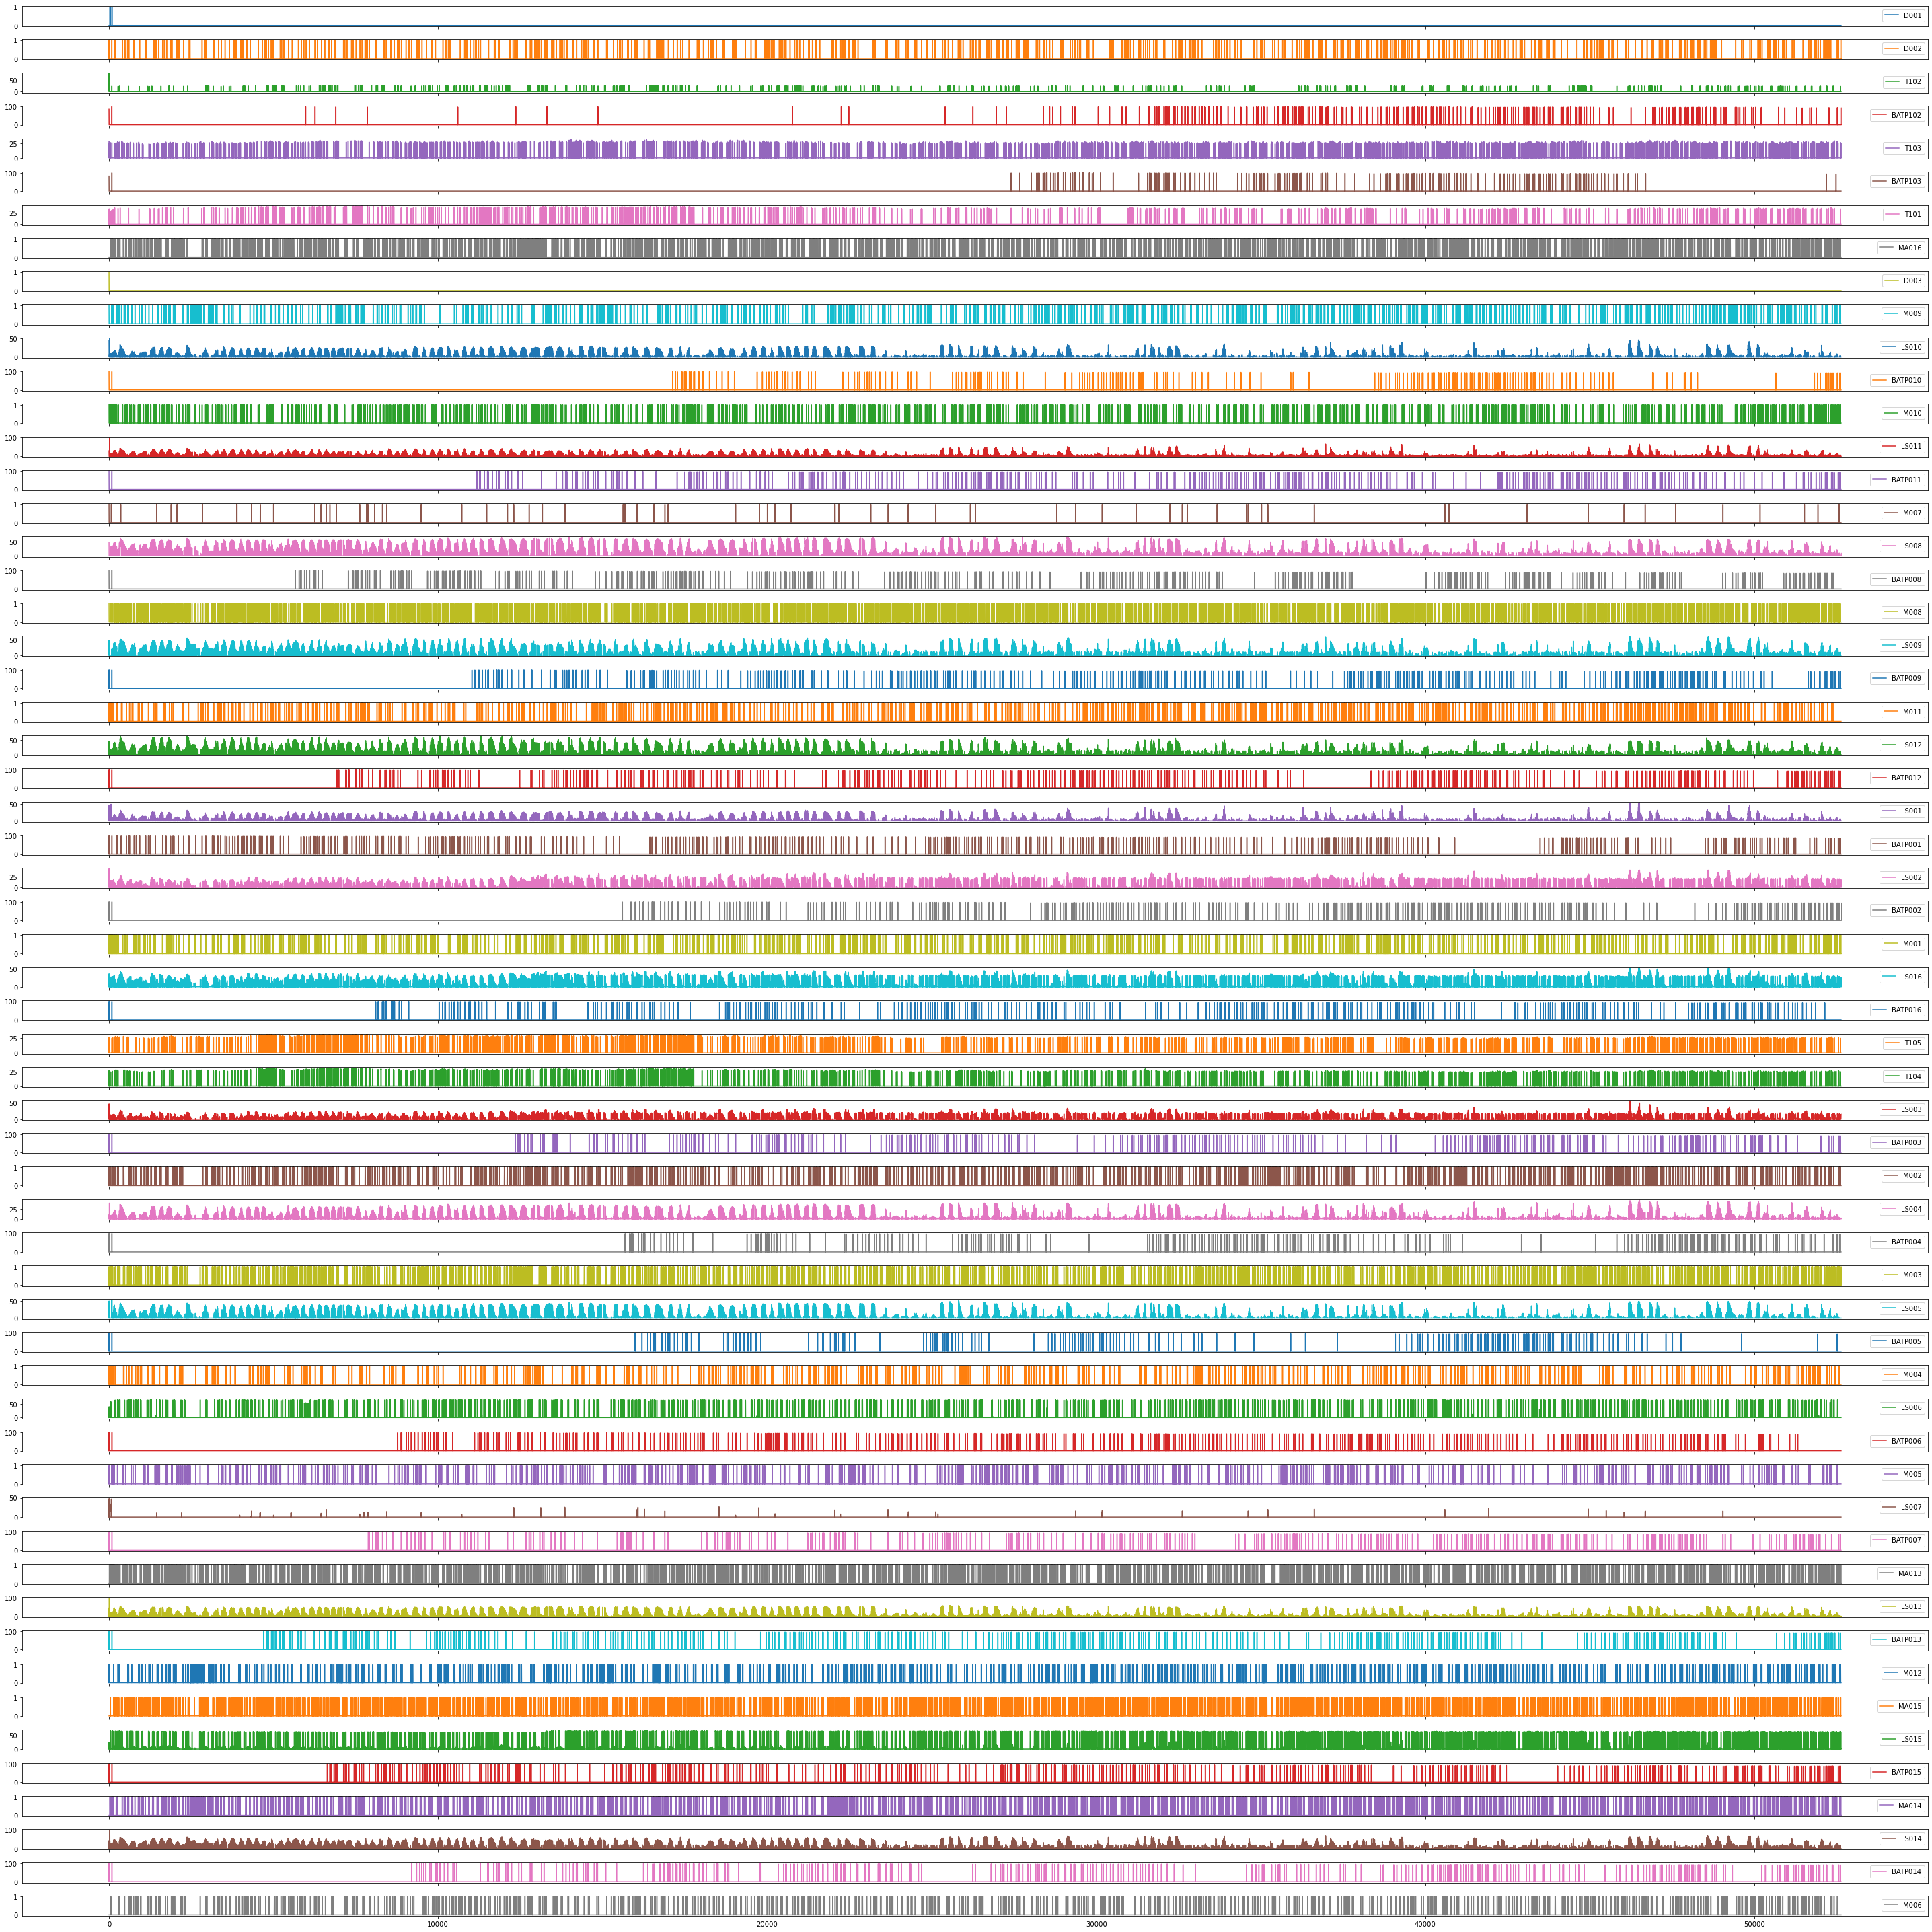

In [4]:
reversed_mapping = {y: x for x, y in sensor_id_mapping.items()}
changed_legend = new_data.rename(columns = reversed_mapping)

changed_legend.plot(subplots=True, figsize=(40,40))
pyplot.tight_layout()
pyplot.savefig("data_plots/CleanedData.png", format="png", dpi=1200)

now create a scatter plot of the data at each time step

In [ ]:
# changed_legend.plot(figsize=(30,30))
# pyplot.tight_layout()
# pyplot.savefig("plots/idk.png", format="png", dpi=1200)

Now need to transform the data into a sequence form so that we have predicted labels for each row of data

In [5]:
df = changed_legend.copy()
df.drop(columns="Time", inplace=True)
# scale values
values = df.values
min_max_scaler = MinMaxScaler()
scaled_values = min_max_scaler.fit_transform(values)
normalized_df = pandas.DataFrame(scaled_values)
n_vars = len(normalized_df.columns)
cols, names = list(), list()
# input sequence (t-n, ... t-1)
for i in range(1, 0, -1):
    cols.append(normalized_df.shift(i))
    names += [('var%d(t-%d)' % (j+1, i)) for j in range(n_vars)]
# forecast sequence (t, t+1, ... t+n)
for i in range(0, 1):
    cols.append(normalized_df.shift(-i))
    if i == 0:
        names += [('var%d(t)' % (j+1)) for j in range(n_vars)]
    else:
        names += [('var%d(t+%d)' % (j+1, i)) for j in range(n_vars)]
# put it all together
agg = concat(cols, axis=1)
agg.columns = names
# drop rows with NaN values
agg.dropna(inplace=True)
print(agg.head)

<bound method NDFrame.head of        var1(t-1)  var2(t-1)  var3(t-1)  var4(t-1)  var5(t-1)  var6(t-1)  \
1            0.0        1.0    0.95122       0.85   0.806452       0.82   
2            0.0        0.0    0.00000       0.00   0.000000       0.00   
3            0.0        0.0    0.00000       0.00   0.000000       0.00   
4            0.0        0.0    0.00000       0.00   0.000000       0.00   
5            0.0        0.0    1.00000       0.00   0.000000       0.00   
...          ...        ...        ...        ...        ...        ...   
52626        0.0        0.0    0.00000       0.94   0.000000       0.00   
52627        0.0        0.0    0.00000       0.00   0.000000       0.00   
52628        0.0        0.0    0.00000       0.00   0.806452       0.00   
52629        0.0        0.0    0.00000       0.00   0.000000       0.00   
52630        0.0        0.0    0.00000       0.00   0.000000       0.00   

       var7(t-1)  var8(t-1)  var9(t-1)  var10(t-1)  ...  var49(t)  va

Now we need to separate into test and train data

In [6]:
values = agg.values
train_split = int(0.8 * len(values))

train = values[:train_split, :]
test = values[train_split:, :]

features = 58
train_x, train_y = train[:, :features], train[:, features:]
test_x, test_y = test[:, :features], test[:, features:]
train_x = np.asarray(train_x).astype(np.float32)
train_y = np.asarray(train_y).astype(np.float32)
test_y = np.asarray(test_y).astype(np.float32)
test_x = np.asarray(test_x).astype(np.float32)
train_x = train_x.reshape((train_x.shape[0], 1, train_x.shape[1]))
test_x = test_x.reshape((test_x.shape[0], 1, test_x.shape[1]))


Now create the network

In [7]:
import pickle

def save_model_and_plot(model, filename):
    pickle.dump(model, open("prediction_models/" +filename +".sav", 'wb'))
    pyplot.plot(history.history['loss'], label='Loss')
    pyplot.plot(history.history['val_loss'], label='Validation Loss')
    pyplot.xlabel("Epochs")
    pyplot.ylabel("Loss")
    pyplot.title("Loss and Validation loss of prediction model before tuning.")
    pyplot.tight_layout()
    pyplot.legend()
    filename = "prediction_plots/" + filename
    pyplot.savefig(filename)

In [13]:
# design network
model = Sequential()
model.add(LSTM(150, return_sequences=True, input_shape=(train_x.shape[1], train_x.shape[2])))
model.add(LSTM(75))
model.add(Dense(features))
model.compile(loss='mean_squared_error', optimizer='adam')
# fit network
history = model.fit(train_x, train_y, epochs=100, batch_size=58, validation_split=0.3, verbose=2, shuffle=False)
# plot history
save_model_and_plot(model, "untuned_prediction_3")

Epoch 1/100


2022-07-20 12:09:35.289437: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:09:35.608165: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:09:35.662181: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:09:35.748794: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:09:35.825544: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:09:41.765970: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:09:41.867842: I tensorflow/core/grappler/optimizers/cust

509/509 - 9s - loss: 0.0201 - val_loss: 0.0190 - 9s/epoch - 18ms/step
Epoch 2/100
509/509 - 6s - loss: 0.0193 - val_loss: 0.0188 - 6s/epoch - 12ms/step
Epoch 3/100
509/509 - 6s - loss: 0.0191 - val_loss: 0.0187 - 6s/epoch - 12ms/step
Epoch 4/100
509/509 - 6s - loss: 0.0190 - val_loss: 0.0187 - 6s/epoch - 12ms/step
Epoch 5/100
509/509 - 6s - loss: 0.0190 - val_loss: 0.0186 - 6s/epoch - 12ms/step
Epoch 6/100
509/509 - 6s - loss: 0.0189 - val_loss: 0.0186 - 6s/epoch - 11ms/step
Epoch 7/100


Now test the model

In [11]:
from numpy import concatenate
from math import sqrt
from sklearn.metrics import mean_squared_error

# make a prediction
yhat = model.predict(test_x)
test_x = test_x.reshape((test_x.shape[0], 58))
print(yhat)
# # calculate RMSE
rmse = sqrt(mean_squared_error(test_y, yhat))
print('Test RMSE: %.3f' % rmse)


2022-07-20 12:06:02.174101: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:06:02.295047: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.
2022-07-20 12:06:02.355328: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


329/329 [==============================] - 2s 4ms/step
[[ 6.64735035e-06  5.20386212e-02  3.73326638e-03 ...  2.07040757e-02
   1.53553691e-02 -1.62475556e-03]
 [-6.88062755e-07  2.12728549e-02  7.48790614e-03 ...  1.78538598e-02
   2.26192810e-02  8.37675296e-03]
 [-1.64367557e-05  7.85747916e-03  1.35120368e-02 ...  8.10920447e-03
   2.20246147e-02  4.55027074e-03]
 ...
 [-7.70390670e-06  5.92616312e-02  1.13741476e-02 ... -9.08255577e-04
   1.35978535e-02 -2.72382796e-03]
 [-1.38215364e-05  1.17497463e-02  5.37403254e-03 ... -6.24001026e-04
   1.51230954e-02  1.41694695e-01]
 [ 2.25837466e-05 -7.77753629e-03 -2.93734483e-05 ... -6.13595545e-03
   1.68783050e-02  3.41352016e-01]]
Test RMSE: 0.139


Now try to do some anomaly detection
So maybe keep a portion of the data back and insert anomalies?

In [ ]:
anomaly_free_x_values = None
anomaly_inserted_y_vales = None

predictions = None



In [ ]:
# Try generating some anomalous data
# One idea is to just scale data to be bigger than 1, in theory this is an anomaly but isn't really in the expected range of input...
# https://github.com/tirthajyoti/Synthetic-data-gen/blob/master/Notebooks/Time%20series%20synthesis%20with%20anomaly.ipynb
anomaly_frac = 0.2
one_sided = False
new_arr = agg.copy()
arr_min = new_arr.min()
arr_max = new_arr.max()
no_anomalies = int(new_arr.size * anomaly_frac)
idx_list = np.random.choice(a=new_arr.size , size=no_anomalies, replace=False)
for idx in idx_list:
    if one_sided:
        new_arr[idx] = self.loc + np.random.uniform(
            low=arr_min, high=anomaly_scale * (arr_max - arr_min)
        )
    else:
        new_arr[idx] = self.loc + np.random.uniform(
            low=-anomaly_scale * (arr_max - arr_min),
            high=anomaly_scale * (arr_max - arr_min),
        )
self.anomalized_data = new_arr
self._anomaly_flag_ = True

if return_df:
    df = pd.DataFrame(
        {"time": self.time_arr, "anomaly_data": self.anomalized_data}
    )
    return df
else:
    return self.anomalized_data

var1(t-1)     0.0
var2(t-1)     0.0
var3(t-1)     0.0
var4(t-1)     0.0
var5(t-1)     0.0
var6(t-1)     0.0
var7(t-1)     0.0
var8(t-1)     0.0
var9(t-1)     0.0
var10(t-1)    0.0
var11(t-1)    0.0
var12(t-1)    0.0
var13(t-1)    0.0
var14(t-1)    0.0
var15(t-1)    0.0
var16(t-1)    0.0
var17(t-1)    0.0
var18(t-1)    0.0
var19(t-1)    0.0
var20(t-1)    0.0
var1(t)       0.0
var2(t)       0.0
var3(t)       0.0
var4(t)       0.0
var5(t)       0.0
var6(t)       0.0
var7(t)       0.0
var8(t)       0.0
var9(t)       0.0
var10(t)      0.0
var11(t)      0.0
var12(t)      0.0
var13(t)      0.0
var14(t)      0.0
var15(t)      0.0
var16(t)      0.0
var17(t)      0.0
var18(t)      0.0
var19(t)      0.0
var20(t)      0.0
dtype: float64


/var/folders/cy/ykpjhkhn2q5f0x_yjxc7ymfr0000gn/T/ipykernel_38262/928903321.py:6: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  arr_min = new_arr.min()
/var/folders/cy/ykpjhkhn2q5f0x_yjxc7ymfr0000gn/T/ipykernel_38262/928903321.py:8: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  arr_max = new_arr.max()


NameError: name 'self' is not defined